# Slider Experiment

In [1]:
import csv
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import scikit_posthocs as ph
import scipy.stats as stats
import seaborn as sns

from collections import OrderedDict
from tabulate import tabulate

sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['patch.linewidth'] = 0.0

palette = sns.color_palette("magma", 4)

# Log parsing code

In [2]:
class Log:
    def __init__(self, PID, gesture, task, target, block, startTime, endTime, frames=None):
        self.PID = PID
        self.gesture = gesture
        self.task = task
        self.target = target
        self.block = block
        self.startTime = startTime
        self.endTime = endTime
        if frames is None:
            self.frames = []
        else:
            self.frames = frames

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

class Frame:
    def __init__(self, activity, state, cursor_X, cursor_y, slider_position_X, slider_value, message=""):
        self.activity = activity
        self.state = state
        self.cursor_X = cursor_X
        self.cursor_y = cursor_y
        self.slider_position_X = slider_position_X
        self.slider_value = slider_value
        self.message = message

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

def extract_data(jsonData):
    """
    Parse json into an instance of the Log class.
    """
    frames = []

    for f in jsonData["frames"]:
        frames.append(Frame(f["activity"], f["state"], f["cursor_X"], f["cursor_y"], f["slider_position_X"], f["slider_value"], f["message"] if "message" in f else ""))

    return Log(jsonData["PID"], jsonData["gesture"], jsonData["task"], jsonData["target"], jsonData["block"], jsonData["startTime"], jsonData["endTime"], frames)

def block_success(data: Log):
    """
    Determine task success based on the final slider value.
    """
    return data.frames[-1].slider_value == data.target

def time(data: Log):
    """
    Calculate overall task time and time taken for first land on a target.
    """
    n_frames = 0
    time_start = data.startTime
    time_end = data.endTime
    
    time = time_end - time_start
    time_calculated = False
    
    time_hit = -1
    time_hit_calculated = False
    
    for frame in data.frames:
        n_frames += 1
        ratio = n_frames / float(len(data.frames))
        
        if (not time_calculated) and frame.message.startswith("Transitioning from states NoHands to"):
            time_start = data.startTime + ((time_end - time_start) * ratio)
            time = time_end - time_start
            time_calculated = True
            
            time_hit = time # Set this now as a fallback
        
        if time_calculated and frame.slider_value == data.target:
            time_hit = ratio * (time_end - time_start)
            time_hit_calculated = True
        
        if time_calculated and time_hit_calculated:
            break

    if time_hit_calculated:
        return (time, time_hit)
    else:
        return (time, -1)

def overshoots(data: Log):
    """
    Count the number of target overshoots. There are two types of overshoot: going above and
    going below the target value. These are counted when the selected slider value moves over
    the target in a sequence. Might be some bugs with this, e.g., if the slider never perfectly
    sets on the target.
    """
    overList = []
    overCount = 0
    
    # Has crossed to a higher value
    crossed_above = False
    
    # Has crossed to a lower value
    crossed_below = False
    
    for frame in data.frames:
        if frame.slider_value > data.target:
            if not crossed_above:
                crossed_above = True
                crossed_below = False
                
                overCount += 1
                
            overList.append(frame.slider_value)
        else:
            crossed_above = False
            
            if frame.slider_value == data.target:
                crossed_below = True # Not true, but we need to know when we fall off the other side
            else:
                if crossed_below:
                    crossed_below = False
                    
                    overCount += 1
                
                overList.append(frame.slider_value)
            
    return (overList, overCount)

def target_distance(data: Log):
    """
    Calculates the distance in pixels between the target and the final cursor position.
    """
    return 0

def count_engagements(data: Log):
    """
    Calculates the number of times the user 'engaged' the slider.
    """
    engaged = False
    count = 0
    
    for frame in data.frames:
        if frame.message in ["Transitioning from states NoPinchDetected to PinchDetected", "Transitioning from states NoDwellDetected to DwellDetected"]:
            count += 1
    
    return count

def slider_loc(data: Log):
    """
    Returns the final slider coordinate.
    """
    return ((data.frames[-1].slider_position_X))

# Import log data

In [3]:
columnNames = ["P", "B", "Condition", "Task", "Target", "Selected", "Time", "Time to Target", "Success", "Activations", "Overshoots", "Overshoot_Values", "Location"]
data = pd.DataFrame(columns = columnNames)

files = glob.glob("../Logs/*/*/*/*.json")
log: Log

for file in files:
    with open(file) as json_file:
        pid = file.split("/")[2]
        condition = file.split("/")[4]
        task = file.split("/")[3]
        
        if pid != "-1":
            log = extract_data(json.load(json_file))
            
            (task_time, time_to_hit) = time(log)
            success = block_success(log)
            (overshootHits, overshootCount) = overshoots(log)
            activations = count_engagements(log)
            sliderPos = slider_loc(log)
            
            log_data = pd.DataFrame(columns = columnNames, data = [[pid, log.block, condition, task, log.target, log.frames[-1].slider_value, task_time, time_to_hit, success, activations, overshootCount, set(overshootHits), sliderPos]])
            data = data.append(log_data)

In [4]:
# Drop task time outliers
data_filtered = data[data['Time'] <= 30000]
data_filtered = data_filtered[data_filtered['Time'] > 10]
data_filtered = data_filtered[data_filtered['Target'] != "A"]
data_filtered = data_filtered[data_filtered['Target'] != "1"]

print("Kept {} results from {}".format(len(data_filtered), len(data),))

Kept 664 results from 720


# Summary

In [5]:
print("Read data from {} participants".format(len(data.P.unique()),))

data_filtered.agg({'Time': ['mean', 'std', 'min', 'max'], 'Overshoots': ['mean', 'std', 'min', 'max'], 'Activations': ['mean', 'std', 'min', 'max']})

Read data from 4 participants


,Time,Overshoots,Activations
mean,9216.778247,7.635542,35.451807
std,6535.237047,6.552699,25.061988
min,1130.115527,0.000000,2.000000
max,29882.571873,40.000000,168.000000


# Exploratory plots

In [6]:
def point_plot(df, dv, iv, n_iv, max_x, xlab="", ylab="", show_grid=False, show_all=True, plot_w=7, plot_h=2, filename=None):
    """
    Creates a point plot showing mean values with 95% confidence intervals.
    
    df: Data frame.
    dv: Column name with the dependent variable measurements.
    iv: Column name with the independent variable values.
    n_iv: Number of levels in the independent variable.
    max_x: Maximum x-axis value.
    show_grid: If True, show a grid in the plot.
    show_all: If True, include a strip plot.
    plot_w: Plot width in inches.
    plot_h: Plot height in inches.
    filename: If given, save to a pdf with this filename.
    """
    plot, axis = plt.subplots(figsize=(plot_w, plot_h))
    
    if show_all:
        sns.stripplot(x=dv, y=iv, hue=iv, data=df, palette=palette, dodge=True, size=6, alpha=0.1, jitter=1.05)
        
    sns.pointplot(x=dv, y=iv, hue=iv, data=df, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)

    # Adjust legend
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles[0:n_iv], labels[0:n_iv], handletextpad=0, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, 1.0))

    # Adjust axes
    axis.set_ylabel(ylab)
    axis.set_xlabel(xlab)
    axis.set(xlim=(0, max_x))
    axis.yaxis.set_visible(False)
    axis.grid(show_grid)
    
    if show_all:
        axis.margins(x=0.05, y=0.05)

    # Show and save
    plt.show()
    
    if filename is not None:
        plot.savefig(filename, bbox_inches='tight')

## Task time per technique

Plots mean task time per input technique, with 95% confidence intervals.

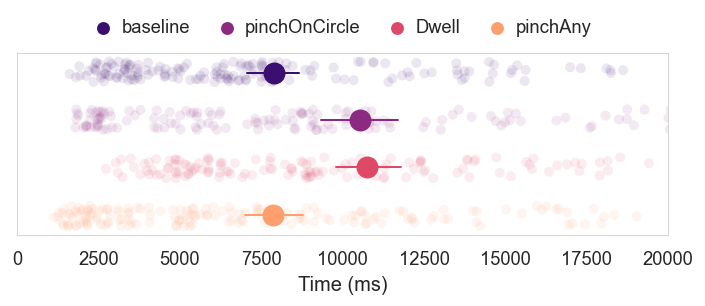

In [7]:
point_plot(data_filtered, "Time", "Condition", 4, 20000, "Time (ms)", plot_w=7, plot_h=2)

## Task time per task type

Plots mean task time per task type, wiht 95% confidence intervals.

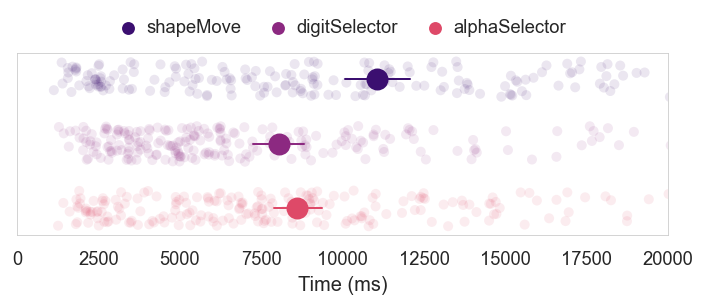

In [8]:
point_plot(data_filtered, "Time", "Task", 3, 20000, "Time (ms)", plot_w=7, plot_h=2)

## Task time for technique x task

Plots the mean task time for each condition and task, with 95% confidence intervals.

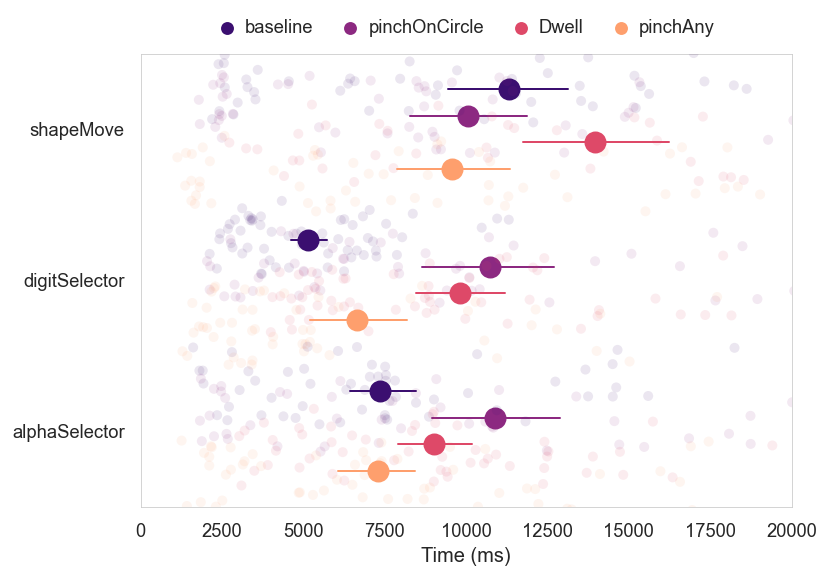

In [9]:
plot, axis = plt.subplots(figsize=(7, 5))

sns.stripplot(x="Time", y="Task", hue="Condition", data=data_filtered, palette=palette, dodge=True, size=6, alpha=0.1, jitter=1.05)
sns.pointplot(x="Time", y="Task", hue="Condition", data=data_filtered, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)

# Adjust legend
handles, labels = axis.get_legend_handles_labels()
axis.legend(handles[0:4], labels[0:4], handletextpad=0, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, 1.0))

# Adjust axes
axis.set_ylabel("")
axis.set_xlabel("Time (ms)")
axis.set(xlim=(0, 20000))
axis.yaxis.set_visible(True)
axis.grid(False)

# Show and save
plt.show()
#plot.savefig('TaskTimeStrip.pdf', bbox_inches='tight')

## Number of target overshoots

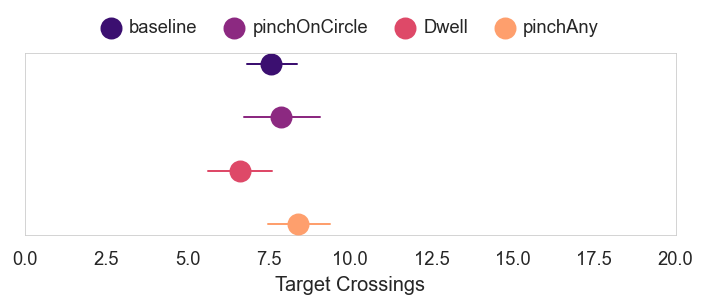

In [10]:
point_plot(data_filtered, "Overshoots", "Condition", 4, 20, "Target Crossings", plot_w=7, plot_h=2, show_all=False)

## Number of cursor activations (i.e., taking control of cursor events)

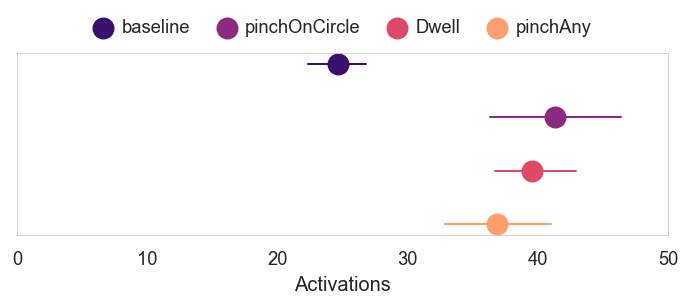

In [11]:
point_plot(data_filtered, "Activations", "Condition", 4, 50, "Activations", plot_w=7, plot_h=2, show_all=False)

# Time to first acquire target

Plots mean time taken for the cursor to first touch the target value. Excludes trials where the target was never directly hit.

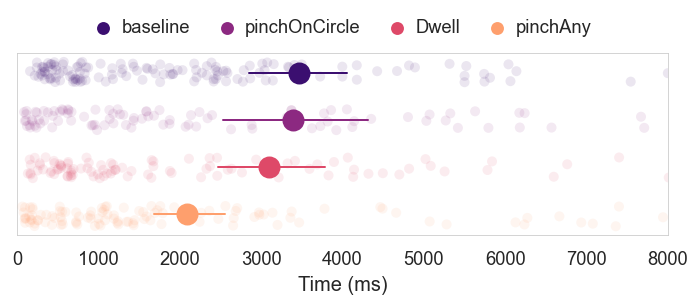

In [12]:
df_hits = data_filtered[data_filtered['Time to Target'] != -1]

point_plot(df_hits, "Time to Target", "Condition", 4, 8000, "Time (ms)", plot_w=7, plot_h=2)

In [13]:
#data_filtered[data_filtered["Time to Target"] < 500]

# Analysis

## Task time

In [17]:
aov_time = pg.rm_anova(dv='Time', within=['Condition', 'Task'], subject='P', data=data)
pg.print_table(aov_time)

print("Remember to ignore comparisons if there is no significant effect!")
ph_time = pg.pairwise_ttests(dv='Time', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=data)
pg.print_table(ph_time)


ANOVA SUMMARY

Source                       SS    ddof1    ddof2            MS      F    p-unc    p-GG-corr    np2    eps
----------------  -------------  -------  -------  ------------  -----  -------  -----------  -----  -----
Condition         205742231.664        3        9  68580743.888  5.425    0.021        0.045  0.644  0.665
Task              162261206.117        2        6  81130603.059  1.622    0.273        0.292  0.351  0.519
Condition * Task  166484482.419        6       18  27747413.737  3.941    0.011        0.140  0.568  0.170

Remember to ignore comparisons if there is no significant effect!

POST HOC TESTS

Contrast          Condition      A              B              Paired    Parametric         T    dof  alternative      p-unc    BF10    cohen
----------------  -------------  -------------  -------------  --------  ------------  ------  -----  -------------  -------  ------  -------
Condition         -              Dwell          baseline       True      True    